In [176]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import *
from lmfit.models import LorentzianModel

['Time (s)', 'Signal']


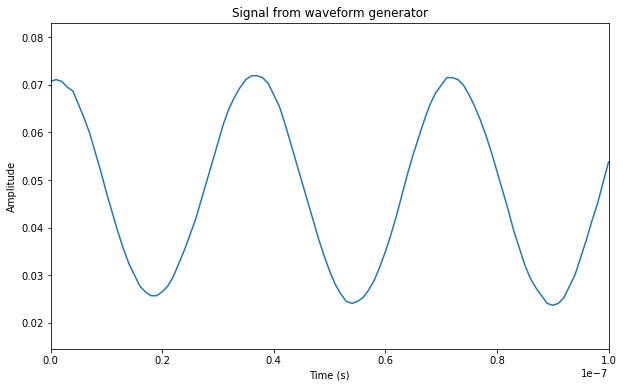

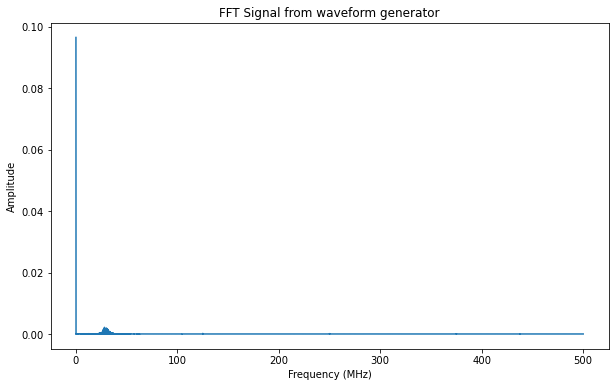

In [294]:
# Beat signal
sample=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230221/L28t1us.csv').iloc[0:,1:2]
#sample=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230212/N1t500us.csv').iloc[0:,1:2]
nsamples = len(sample)

# ----------------
# Time
# ----------------
dt = 1/1e9          #1.e-9
t = pd.Series([i*dt for i in range(nsamples)], name='Time (s)').T

df_sample = pd.DataFrame(t)
df_sample['Signal']=sample


header = list(df_sample.columns)
print(header)

fig1,ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df_sample['Time (s)'],df_sample['Signal'],'-')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0,0.1e-6)
plt.title('Signal from waveform generator')
plt.show()

yf = fft(df_sample['Signal'].values)
xf = fftfreq(nsamples, dt)[:nsamples//2]

fig2,ax2 = plt.subplots(figsize=(10,6))
ax2.plot(xf*1e-6, 2.0/nsamples * np.abs(yf[0:nsamples//2]))
plt.title('FFT Signal from waveform generator')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
# plt.xlim(0,1e-9)
#plt.grid()
plt.show()

In [295]:
df_sample

,Time (s),Signal
0,0.000000e+00,0.070675
1,1.000000e-09,0.071076
2,2.000000e-09,0.070675
3,3.000000e-09,0.069470
4,4.000000e-09,0.068667
...,...,...
131067,1.310670e-04,0.035337
131068,1.310680e-04,0.032125
131069,1.310690e-04,0.028912
131070,1.310700e-04,0.026503


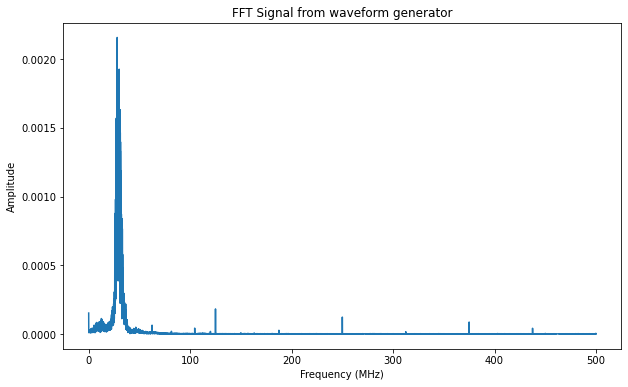

In [296]:
# Peakfinder

peaks, _ = find_peaks(2.0/nsamples * np.abs(yf[0:nsamples//2]))

peakfreq = pd.Series(xf[peaks]*1e-6,name='Frequency(MHz)')
peakamp = pd.Series(2.0/nsamples * np.abs(yf[0:nsamples//2])[peaks], name='Amplitude')

df_peak = pd.DataFrame(peakfreq)
df_peak['Amplitude']=peakamp

df_peak[df_peak.Amplitude > 0.00004]

fig3,ax3 = plt.subplots(figsize=(10,6))
# ax3.plot(df_peak['Frequency(MHz)'],df_peak['Amplitude'])
ax3.plot(peakfreq,peakamp)
plt.title('FFT Signal from waveform generator')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
# plt.xlim(0,1)
#plt.grid()
plt.show()

In [297]:
xf[:8]-xf[1:9]

array([-7629.39453125, -7629.39453125, -7629.39453125, -7629.39453125,
       -7629.39453125, -7629.39453125, -7629.39453125, -7629.39453125])

In [284]:
def FFT3D(C,n,times):
    if times/5e-9 == 1: #5 ns
        a = 5
        text = 'ns'
    elif times/100e-9 == 1: # 100ns
        a = 100
        text ='ns'
    elif times/500e-6 == 1: #500us
        a = 500
        text='us'
    elif times/1e-6 == 1: # 1us
        a = 1
        text='us'
    elif times/10e-3 == 1: # 10ms
        a = 10
        text = 'ms'
    elif times/1e-3 == 1 : # 1ms
        a = 1
        text = 'ms'
    elif times/1e0 == 1:
        a = 1
        text = 's'
    else:
        print('No such file or directory')
    
    sample=pd.read_csv(r'D:/Thesis 4th year/Oscilloscope/230221/'+str(C)+''+str(n)+'t'+str(a)+''+str(text)+'.csv').iloc[0:,1:2]
    textf='file name: '+str(C)+''+str(n)+'t'+str(a)+''+str(text)+''
    
    nsamples = len(sample)
    
    if times == 500e-6 or times == 100e-9 or times == 5e-9 or times == 1e-6:
        dt = 1.e-9 # 1/(1GSa/s) or 1/1.e9 
    elif times == 1e-3:
        dt = 1/500e6 #1/(500MSa/s)
    elif times == 10e-3:
        dt = 1/50e6
    elif times == 1:
        dt=1/2e6
    dtr='dt: '+str(dt)+''
    
    t = pd.Series([i*dt for i in range(nsamples)], name='Time (s)').T  
    df_sample = pd.DataFrame(t)
    df_sample['Signal']=sample
    header = list(df_sample.columns)
    
    yf = fft(df_sample['Signal'].values)
    xf = fftfreq(nsamples, dt)[:nsamples//2]
    
    # Peakfinder
    peaks, _ = find_peaks(2.0/nsamples * np.abs(yf[0:nsamples//2]))

    peakfreq = pd.Series(xf[peaks]*1e-6,name='Frequency(MHz)')
    peakamp = pd.Series(2.0/nsamples * np.abs(yf[0:nsamples//2])[peaks], name='Amplitude')

    df_peak = pd.DataFrame(peakfreq)
    df_peak['Amplitude']=peakamp
    df_peak[df_peak.Amplitude > 0.00000]
    
    return peakfreq,peakamp,dtr,textf

def lff(A):
    x=A[0]
    X=x
    Y=A[1].values.flatten()
    mod = LorentzianModel()
    pars = mod.guess(Y, x=X)
    out = mod.fit(Y, pars, x=X)
    print(out.fit_report(min_correl=0.005))
    a=out.params['amplitude'].value
    c=out.params['center'].value
    s=out.params['sigma'].value
    f=out.params['fwhm'].value
    return a,c,s,f

def plotFFT(A,a,c,s,f):
    x=A[0]
    mu=c
    sigma=s
    fwhm=f
    lor=(a/(np.pi))*(sigma/((x-mu)**2+sigma**2))
    fig, ax = plt.subplots(figsize=(15, 9))
    plt.plot(A[0],A[1])
    plt.plot(A[0],lor,"--")
    #plt.xlim(0,50)
    return 

def FFTP(C,n,times):
    A=FFT3D(C,n,times)
    A1=lff(FFT3D(C,n,times))
    print('linewidth :',A1[3],'MHz')
    plotFFT(A,A1[0],A1[1],A1[2],A1[3])
    return A[2],A[3]

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 21858
    # variables        = 3
    chi-square         = 1.5226e-05
    reduced chi-square = 6.9670e-10
    Akaike info crit   = -460865.514
    Bayesian info crit = -460841.538
    R-squared          = 0.84824575
[[Variables]]
    amplitude:  0.00716649 +/- 2.8832e-05 (0.40%) (init = 0.01477299)
    center:     38.9572489 +/- 0.01572326 (0.04%) (init = 38.97637)
    sigma:      3.94126747 +/- 0.02201086 (0.56%) (init = 3.707914)
    fwhm:       7.88253495 +/- 0.04402172 (0.56%) == '2.0000000*sigma'
    height:     5.7879e-04 +/- 2.2220e-06 (0.38%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.005)
    C(amplitude, sigma)  = 0.726
    C(center, sigma)     = -0.024
    C(amplitude, center) = -0.015
linewidth : 7.882534945814575 MHz


('dt: 1e-09', 'file name: L11t500us')

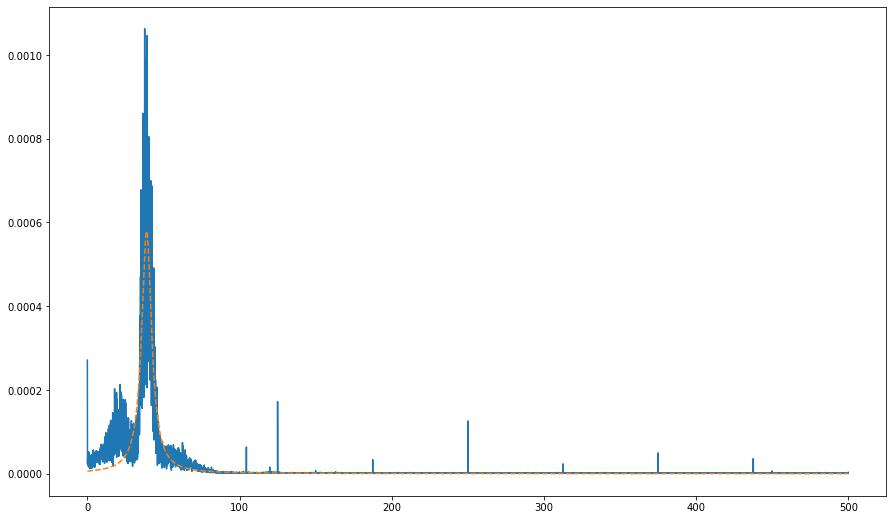

In [352]:
FFTP('L',11,500e-6)